In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from tqdm import tqdm
from IPython.display import clear_output

import Model.my_model
import importlib

import yaml

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, state_dim, action_dim, nhead, num_encoder_layers, num_decoder_layers, d_model, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Embedding layers for states and actions
        self.state_embedding = nn.Linear(state_dim, d_model)
        self.action_embedding = nn.Linear(action_dim, d_model)

        # Transformer Encoder and Decoder
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, 
                                          num_encoder_layers=num_encoder_layers, 
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward)

        # Final output layer to predict the 5th action
        self.fc_out = nn.Linear(d_model, action_dim)
    
    def forward(self, states, actions):
        # Embed states and actions
        state_embed = self.state_embedding(states)  # (batch_size, seq_length, d_model)
        action_embed = self.action_embedding(actions)  # (batch_size, seq_length, d_model)

        # Prepare input for transformer
        state_embed = state_embed.permute(1, 0, 2)  # (seq_length, batch_size, d_model)
        action_embed = action_embed.permute(1, 0, 2)  # (seq_length, batch_size, d_model)

        # Forward pass through transformer
        transformer_output = self.transformer(state_embed, action_embed)  # (seq_length, batch_size, d_model)

        # Output the predicted 5th action (output of the last sequence step)
        output = self.fc_out(transformer_output[-1, :, :])  # (batch_size, action_dim)
        return output

## Dataset
We load the dataset and normalize the values

In [3]:
class TrajectoryDataset(Dataset):
    
    def __init__(self, data, sequence_length=5, normalize=False):
        self.data = data
        self.sequence_length = sequence_length
        
        self.state_keys = ['s', 'e', 'dtheta', 'vx', 'vy']
        self.action_keys = ['throttle', 'steering']

        self.raw_sequences = []  # To store state-action pairs
        
        for key, trajectory in self.data.items():
            states = list(zip(*[trajectory[state_key] for state_key in self.state_keys]))
            actions = list(zip(*[trajectory[action_key] for action_key in self.action_keys]))
            
            for i in range(len(states) - sequence_length):
                # Get sequence of 5 states and 4 actions, then the 5th action as the target
                state_sequence = states[i:i+sequence_length]  # First 5 states
                action_sequence = actions[i:i+sequence_length-1]  # First 4 actions
                next_action = actions[i+sequence_length-1]  # 5th action as the target

                # Append input (5 states, 4 actions) and output (5th action)
                self.raw_sequences.append((state_sequence, action_sequence, next_action))

        # Convert the sequences to arrays
        self.sequences = np.array([seq[0] for seq in self.raw_sequences], dtype=np.float32)  # States
        self.action_sequences = np.array([seq[1] for seq in self.raw_sequences], dtype=np.float32)  # Actions
        self.next_actions = np.array([seq[2] for seq in self.raw_sequences], dtype=np.float32)  # Targets (5th action)

        # Normalize if required
        if normalize:
            self.state_mean = self.sequences.mean(axis=(0, 1))
            self.state_std = self.sequences.std(axis=(0, 1))
            self.action_mean = self.action_sequences.mean(axis=(0, 1))
            self.action_std = self.action_sequences.std(axis=(0, 1))

            scaling_params = {
                'mean': (self.state_mean.tolist(), self.action_mean.tolist()),
                'std': (self.state_std.tolist(), self.action_std.tolist())
            }

            with open('./Model/scaling_params_2.json', 'w') as f:
                json.dump(scaling_params, f)

            # Normalize states and actions
            self.sequences = (self.sequences - self.state_mean) / (self.state_std + 1e-8)
            self.action_sequences = (self.action_sequences - self.action_mean) / (self.action_std + 1e-8)

    def __len__(self):
        return len(self.raw_sequences)

    def __getitem__(self, idx):
        states = torch.tensor(self.sequences[idx], dtype=torch.float32)  # Shape: (5, state_dim)
        actions = torch.tensor(self.action_sequences[idx], dtype=torch.float32)  # Shape: (4, action_dim)
        target_action = torch.tensor(self.next_actions[idx], dtype=torch.float32)  # Shape: (action_dim)
        return states, actions, target_action


In [4]:
with open('all_trajectories.yaml', 'r') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

In [5]:

from torch.utils.data import random_split

dataset = TrajectoryDataset(data, sequence_length=5, normalize=False)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model
Pytorch model and the hyperparameters used for training

In [6]:
state_dim = 5
action_dim = 2

model = TransformerModel(state_dim= state_dim, action_dim=action_dim, 
                         d_model=64, nhead=4, num_encoder_layers=1, 
                         num_decoder_layers=0, dim_feedforward=128)

criterion = nn.HuberLoss(delta = 0.75)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used : ", device)

model.to(device)
criterion.to(device)

num_epochs = 10

optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

Device used :  cpu


## Training loop

In [7]:
train_losses = []
test_losses = []
best_test_loss = np.inf
early_stopping_patience = 10


for epoch in range(num_epochs):
    model.train()
    
    train_loss = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for batch in pbar:
            state_trajectories = batch[0].to(device) 
            
            input_actions = batch[1].to(device)
         
            target_action = batch[2].to(device)  
            
            optimizer.zero_grad()
        
            outputs = model(state_trajectories, input_actions)
        
            loss = criterion(outputs, target_action)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.5f}')
    
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            state_trajectories = batch[0].to(device)
            input_actions = batch[1].to(device)
            target_action = batch[2].to(device)
            
            outputs = model(state_trajectories, input_actions)
            
            loss = criterion(outputs, target_action)
            total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    scheduler.step(avg_test_loss)

    print(f'  Test Loss: {avg_test_loss:.5f}')
    
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        torch.save(model.state_dict(), './Model/model_4.pth')
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break


Epoch 1/10: 100%|██████████| 4588/4588 [00:41<00:00, 111.22it/s]


Epoch 1/10, Train Loss: 0.00112
  Test Loss: 0.00017


Epoch 2/10: 100%|██████████| 4588/4588 [00:42<00:00, 108.59it/s]


Epoch 2/10, Train Loss: 0.00010
  Test Loss: 0.00006


Epoch 3/10: 100%|██████████| 4588/4588 [00:44<00:00, 103.92it/s]


Epoch 3/10, Train Loss: 0.00005
  Test Loss: 0.00004


Epoch 4/10: 100%|██████████| 4588/4588 [00:39<00:00, 115.30it/s]


Epoch 4/10, Train Loss: 0.00004
  Test Loss: 0.00005


Epoch 5/10: 100%|██████████| 4588/4588 [00:43<00:00, 105.71it/s]


Epoch 5/10, Train Loss: 0.00004
  Test Loss: 0.00004


Epoch 6/10: 100%|██████████| 4588/4588 [00:40<00:00, 111.97it/s]


Epoch 6/10, Train Loss: 0.00004
  Test Loss: 0.00004


Epoch 7/10: 100%|██████████| 4588/4588 [00:43<00:00, 104.60it/s]


Epoch 7/10, Train Loss: 0.00004
  Test Loss: 0.00004


Epoch 8/10: 100%|██████████| 4588/4588 [00:41<00:00, 110.30it/s]


Epoch 8/10, Train Loss: 0.00004
  Test Loss: 0.00003


Epoch 9/10: 100%|██████████| 4588/4588 [00:41<00:00, 111.28it/s]


Epoch 9/10, Train Loss: 0.00004
  Test Loss: 0.00004


Epoch 10/10: 100%|██████████| 4588/4588 [00:40<00:00, 112.47it/s]


Epoch 10/10, Train Loss: 0.00004
  Test Loss: 0.00004


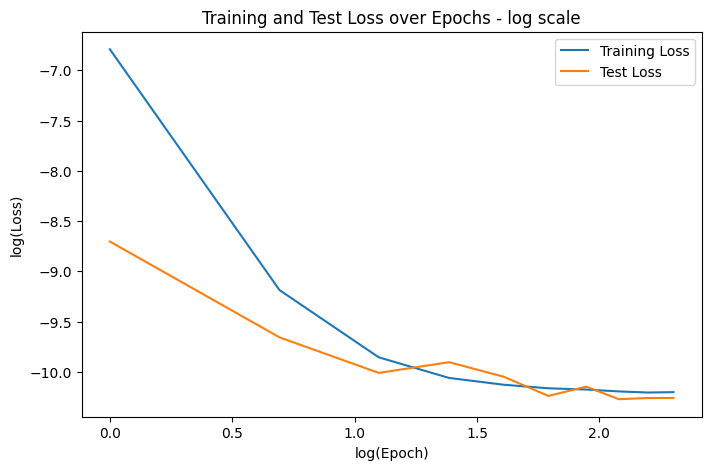

In [8]:
    plt.close("all")
    plt.figure(figsize=(8, 5))
    plt.plot(np.log(range(1, epoch+2)), np.log(train_losses), label='Training Loss')
    plt.plot(np.log(range(1, epoch+2)), np.log(test_losses), label='Test Loss')
    plt.xlabel('log(Epoch)')
    plt.ylabel('log(Loss)')
    plt.title('Training and Test Loss over Epochs - log scale')
    plt.legend()
    plt.show()
    plt.pause(0.001)

In [ ]:
# load the model and test it
model.load_state_dict(torch.load('./Model/model_4.pth'))
model.eval()

test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        state_trajectories = batch[0].to(device)
        input_actions = batch[1].to(device)
        target_action = batch[2].to(device)

        outputs = model(state_trajectories, input_actions)

        loss = criterion(outputs, target_action)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'Final Test Loss: {avg_test_loss:.5f}')

